In [16]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.2")

In [17]:
# State
from pydantic import BaseModel
from typing import Annotated
from langgraph.graph import add_messages
from langchain_core.messages import AnyMessage

class State(BaseModel):
  messages: Annotated[list[AnyMessage], add_messages]
  summary: str = ''

In [18]:

# node
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

def conversation_node(state):
  if state.summary:
    sys_msg = f"""
    You are an helpful assitant. 
    The previous conversation with the user is summarized here. 
    Earlier conversation summary: {state.summary}
    """
    messages = [SystemMessage(content=sys_msg)] + state.messages
  else:
    messages = state.messages
    
  return {
    'messages': llm.invoke(messages)
  }
  
def second_conv_node(state):
  sys_msg = """"Always respond after using `====================================================` as a header"""
  return {
    'messages': llm.invoke([SystemMessage(content=sys_msg)] + [state.messages[-1]])
  }
  
def thinking_node(state):
  sys_msg = """
  1. Always respond after using {{{{{{{{{{{{THINKING}}}}}}}}}}}} as a header
  2. There are two different users. The user with the name "Admin" is a user who is asking you about the status of your conversation with the other user.
  """
  response = llm.invoke([SystemMessage(content=sys_msg)] + state.messages + [HumanMessage(content="What do you think about the above conversations?", name="Admin")])
  print(response)
  
  
def summarization_node(state):
  if state.summary:
    messages = f"""
    This is the conversation summary of the previous conversations: {state.summary}
    
    Extend the summary with the new conversation.
    """
  else:
    messages = """
    Create a summary of the above conversation.
    """
  
  response = llm.invoke(state.messages + [HumanMessage(content=messages)])
  print("---" * 25)
  print(f"{response = }\n\n")
  return {
    'summary': response['content'],
    'messages': [RemoveMessage(id=m.id) for m in state.messages[:-2]]
  }

# Edge

def summarize_condition(state):
  if len(state.messages) > 5:
    return 'summarization_node'
  return '__end__'
    

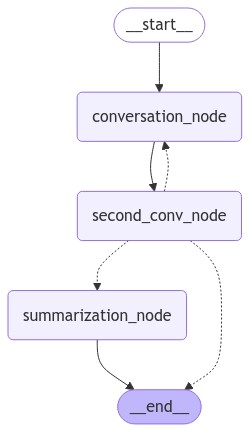

In [19]:
# graph
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.sqlite import SqliteSaver
from sqlite3 import connect

builder = StateGraph(State)

builder.add_node(conversation_node)
builder.add_node(second_conv_node)
# builder.add_node(thinking_node)
builder.add_node(summarization_node)

builder.add_edge(START, 'conversation_node')
# builder.add_edge(START, 'thinking_node')
builder.add_edge('conversation_node', 'second_conv_node')
builder.add_conditional_edges('second_conv_node', summarize_condition)
builder.add_edge('summarization_node', END)

db_path = "db/streaming.db"
conn = connect(db_path, check_same_thread=False)

memory = SqliteSaver(conn)
graph = builder.compile() # checkpointer=memory

from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
config = {'configurable': {'thread_id': 1}}

msg = "Hi, my name is Stephen"
state = {
  'messages': [HumanMessage(msg)]
}

header = " THIS IS INVOKE "
print("==" * 10  + header + "==" * 10 + "\n\n")
graph.invoke(state, stream_mode='updates')


==================== THIS IS INVOKE ====================




[{'conversation_node': {'messages': AIMessage(content="Hello Stephen! It's nice to meet you. Is there something I can help you with or would you like to chat for a bit?", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-10-23T15:20:36.5519386Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 626117000, 'load_duration': 29637300, 'prompt_eval_count': 31, 'prompt_eval_duration': 47194000, 'eval_count': 29, 'eval_duration': 547913000}, id='run-c30a463d-8357-4615-be84-6d36db285973-0', usage_metadata={'input_tokens': 31, 'output_tokens': 29, 'total_tokens': 60})}},
 {'second_conv_node': {'messages': AIMessage(content=" \n\nIf you're looking for a conversation, feel free to share your thoughts on the topic that interests you most. If it's related to a specific question, please provide more details so I can assist you effectively.\n\nLooking forward to our interaction!", additional_kwargs={}, response_me

In [21]:
config = {'configurable': {'thread_id': 1}}

msg = "Hi, my name is Stephen"
state = {
  'messages': [HumanMessage(msg)]
}

header = " THIS IS STREAM {None} "
print("==" * 10  + header + "==" * 10 + "\n\n")
stream = graph.stream(state)
# None
for event in stream:
  print(event)
  print('---' * 25)
  

==================== THIS IS STREAM {None} ====================


{'conversation_node': {'messages': AIMessage(content="Hello Stephen! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-10-23T15:20:38.1946271Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 562940100, 'load_duration': 30618100, 'prompt_eval_count': 31, 'prompt_eval_duration': 47909000, 'eval_count': 26, 'eval_duration': 483878000}, id='run-748aad43-7575-4d99-a77b-303870449c6a-0', usage_metadata={'input_tokens': 31, 'output_tokens': 26, 'total_tokens': 57})}}
---------------------------------------------------------------------------
{'second_conv_node': {'messages': AIMessage(content=" \n\nIf you need assistance, please let me know what's on your mind. If not, we can discuss topics like books, movies, or hobbies. Just let me know how I can be

In [42]:
config = {'configurable': {'thread_id': 1}}

msg = "Hi, my name is Stephen"
state = {
  'messages': [HumanMessage(msg)]
}

header = " THIS IS STREAM {UPDATES} "
print("==" * 10  + header + "==" * 10 + "\n\n")

for event in graph.stream(state, stream_mode="updates"):
  [node] = event.keys()
  print(f"{node = }")
  print(event[node])
  print('---' * 25)

==================== THIS IS STREAM {UPDATES} ====================


node = 'conversation_node'
{'messages': AIMessage(content="Hello Stephen! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-10-23T15:25:26.345279Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 668621600, 'load_duration': 24037800, 'prompt_eval_count': 31, 'prompt_eval_duration': 81989000, 'eval_count': 26, 'eval_duration': 560985000}, id='run-f56d60e9-0114-4448-8495-fef6a6052dfd-0', usage_metadata={'input_tokens': 31, 'output_tokens': 26, 'total_tokens': 57})}
---------------------------------------------------------------------------
node = 'second_conv_node'
{'messages': AIMessage(content=" \n\nIf you'd like to ask a question, have a problem you're trying to solve, or just need some company, I'm here to listen and assist in any way I ca

In [43]:
config = {'configurable': {'thread_id': 1}}

msg = "Hi, my name is Stephen"
state = {
  'messages': [HumanMessage(msg)]
}

header = " THIS IS STREAM {VALUES} "
print("==" * 10  + header + "==" * 10 + "\n\n")

for event in graph.stream(state, stream_mode="values"):
  print(event)
  print('---' * 25)

==================== THIS IS STREAM {VALUES} ====================


{'messages': [HumanMessage(content='Hi, my name is Stephen', additional_kwargs={}, response_metadata={}, id='b5e0d5bc-d3a3-4537-9d76-d61ca6f34cb1')]}
---------------------------------------------------------------------------
{'messages': [HumanMessage(content='Hi, my name is Stephen', additional_kwargs={}, response_metadata={}, id='b5e0d5bc-d3a3-4537-9d76-d61ca6f34cb1'), AIMessage(content="Hello Stephen. It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-10-23T15:25:31.5121008Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 584514500, 'load_duration': 47987000, 'prompt_eval_count': 31, 'prompt_eval_duration': 47464000, 'eval_count': 26, 'eval_duration': 487232000}, id='run-961f636f-9b88-4a59-80d8-a0607420c4b9-0', usage_metadata={'input_toke

In [24]:
config = {'configurable': {'thread_id': 1}}

msg = "Hi, my name is Stephen"
state = {
  'messages': [HumanMessage(msg)]
}

# None
async for event in graph.astream(state, stream_mode='updates'):
  print(event)
  print('---' * 25)
  

{'conversation_node': {'messages': AIMessage(content="Hello Stephen! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-10-23T15:20:42.4170648Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 548868400, 'load_duration': 22335600, 'prompt_eval_count': 31, 'prompt_eval_duration': 45732000, 'eval_count': 26, 'eval_duration': 479715000}, id='run-eb78b321-07fc-496b-a056-e1c0d0a5f90d-0', usage_metadata={'input_tokens': 31, 'output_tokens': 26, 'total_tokens': 57})}}
---------------------------------------------------------------------------
{'second_conv_node': {'messages': AIMessage(content=' \n\nIf you have any questions or need assistance, please feel free to ask!', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-10-23T15:20:42.829636Z', 'message': {'role': 'assistant', 'content

In [25]:
config = {'configurable': {'thread_id': 1}}

msg = "Hi, my name is Stephen"
state = {
  'messages': [HumanMessage(msg)]
}

# None
async for event in graph.astream_events(state, stream_mode='updates', version='v2'):
  print(event)
  print('---' * 25)
  
  


{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi, my name is Stephen', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'c9dba037-04cc-4f62-b052-8bc6e22bbe3a', 'metadata': {}, 'parent_ids': []}
---------------------------------------------------------------------------
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi, my name is Stephen', additional_kwargs={}, response_metadata={})]}}, 'name': '__start__', 'tags': ['graph:step:0', 'langsmith:hidden', 'langsmith:hidden'], 'run_id': '4e869402-3ae1-4e55-a223-b6eff975dfeb', 'metadata': {'langgraph_step': 0, 'langgraph_node': '__start__', 'langgraph_triggers': ['__start__'], 'langgraph_path': ('__pregel_pull', '__start__'), 'langgraph_checkpoint_ns': '__start__:ad4806db-fe68-009a-4f8f-7ca9b9a5333c'}, 'parent_ids': ['c9dba037-04cc-4f62-b052-8bc6e22bbe3a']}
--------------------------------------------------------------------------

In [26]:
astream_events =  graph.astream_events(state, version='v2')

stream = graph.stream(state)

In [27]:
stream.__next__()

{'conversation_node': {'messages': AIMessage(content="Hello Stephen. It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-10-23T15:20:45.8331506Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 560806300, 'load_duration': 26606700, 'prompt_eval_count': 31, 'prompt_eval_duration': 45812000, 'eval_count': 26, 'eval_duration': 486880000}, id='run-c6a05578-6bb2-4d85-9c8c-48dae82afc98-0', usage_metadata={'input_tokens': 31, 'output_tokens': 26, 'total_tokens': 57})}}

In [28]:
await astream_events.__anext__()

{'event': 'on_chain_start',
 'data': {'input': {'messages': [HumanMessage(content='Hi, my name is Stephen', additional_kwargs={}, response_metadata={}, id='b482f1cf-8701-46c7-80db-710ee1c2b9fd')]}},
 'name': 'LangGraph',
 'tags': [],
 'run_id': '8921be35-7a8d-465a-82c0-46a410a8395f',
 'metadata': {},
 'parent_ids': []}

In [29]:
# for i in range(50):
#   event = await astream_events.__anext__()
#   node = event['metadata'].get('langgraph_node')
#   print(f"{ node = }  |  { event['event'] = }  | {event['data'].get('chunk') = }  |")  

async for event in astream_events:
  node = event['metadata'].get('langgraph_node')
  if node == "conversation_node" and event['event'] == "on_chat_model_stream": 
    token = event['data']['chunk'].content
    print(token, end='|')
    

Hello| Stephen|!| It|'s| nice| to| meet| you|.| Is| there| something| I| can| help| you| with| or| would| you| like| to| chat|?||